<a href="https://colab.research.google.com/github/pytony4/dap_2020_fall/blob/master/IRM_model_notebook_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline
import scipy.stats as st
import re
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay

### Загружаем файлы

In [3]:
#Загружаем файлы
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():

  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving current_2022.xlsx to current_2022.xlsx
Saving current_2023.xlsx to current_2023.xlsx
Saving defs_2023.xlsx to defs_2023.xlsx
Saving defs_2019.xlsx to defs_2019.xlsx
Saving defs_2020.xlsx to defs_2020.xlsx
Saving defs_2021.xlsx to defs_2021.xlsx
Saving defs_2022.xlsx to defs_2022.xlsx
Saving current_2019.xlsx to current_2019.xlsx
Saving current_2020.xlsx to current_2020.xlsx
Saving current_2021.xlsx to current_2021.xlsx
User uploaded file "current_2022.xlsx" with length 4547204 bytes
User uploaded file "current_2023.xlsx" with length 4631514 bytes
User uploaded file "defs_2023.xlsx" with length 195588 bytes
User uploaded file "defs_2019.xlsx" with length 212968 bytes
User uploaded file "defs_2020.xlsx" with length 211230 bytes
User uploaded file "defs_2021.xlsx" with length 208837 bytes
User uploaded file "defs_2022.xlsx" with length 203452 bytes
User uploaded file "current_2019.xlsx" with length 4321969 bytes
User uploaded file "current_2020.xlsx" with length 4403161 bytes
User 

### Читаем файлы

In [4]:
rows_to_skip = 3
defs_2019 = pd.read_excel('defs_2019.xlsx', skiprows=rows_to_skip)
defs_2020 = pd.read_excel('defs_2020.xlsx', skiprows=rows_to_skip)
defs_2021 = pd.read_excel('defs_2021.xlsx', skiprows=rows_to_skip)
defs_2022 = pd.read_excel('defs_2022.xlsx', skiprows=rows_to_skip)
defs_2023 = pd.read_excel('defs_2023.xlsx', skiprows=rows_to_skip)

current_2019 = pd.read_excel('current_2019.xlsx', skiprows=rows_to_skip)
current_2020 = pd.read_excel('current_2020.xlsx', skiprows=rows_to_skip)
current_2021 = pd.read_excel('current_2021.xlsx', skiprows=rows_to_skip)
current_2022 = pd.read_excel('current_2022.xlsx', skiprows=rows_to_skip)
current_2023 = pd.read_excel('current_2023.xlsx', skiprows=rows_to_skip)

### Собираем все года в один файл

In [5]:
defs_list = [defs_2019, defs_2020, defs_2021, defs_2022, defs_2023]
current_list = [current_2019, current_2020, current_2021, current_2022, current_2023]
year_list = ['2019', '2020', '2021', '2022', '2023']
for i in range(5):
  rename_dict = {}
  columns = defs_list[i].columns
  for column in columns:
    upd_column = column.replace(year_list[i] + ', ', "")
    rename_dict[column] = upd_column
  defs_list[i] = defs_list[i].rename(columns=rename_dict)
  current_list[i] = current_list[i].rename(columns=rename_dict)
defs_data = pd.concat(defs_list)
current_data = pd.concat(current_list)

### Атрибуты используемые для модели

In [6]:
usable_columns = [
    'Активы  всего, RUB',
    'Выручка, RUB',
    'Период погашения кредиторской задолженности, дни',
    'Период погашения дебиторской задолженности, дни',
    'Соотношение совокупного долга к капиталу, %',
    'Соотношение совокупного долга к EBIT, %',
    'Коэффициент обеспеченности собственными оборотными средствами, %',
    'Валовая рентабельность, %',
    'Рентабельность продаж, %',
    'Рентабельность активов (ROA), %',
    'Коэффициент быстрой ликвидности, %',
    'Коэффициент абсолютной ликвидности, %',

    'Внеоборотные активы, RUB',
    'Сальдо денежных потоков от текущих операций, RUB',
    'EBIT, RUB'
    ]

### Создаём новые атрибуты, присваем признак дефолт или нет

In [7]:
defs_short = defs_data[usable_columns].copy()
current_short = current_data[usable_columns].copy()

defs_short['Маржинальность'] = defs_short['EBIT, RUB'] / defs_short['Выручка, RUB']
defs_short['default'] = 1

current_short['Маржинальность'] = current_short['EBIT, RUB'] / current_short['Выручка, RUB']
current_short['default'] = 0

data = pd.concat([defs_short, current_short])

### Анализ пропущенных значений

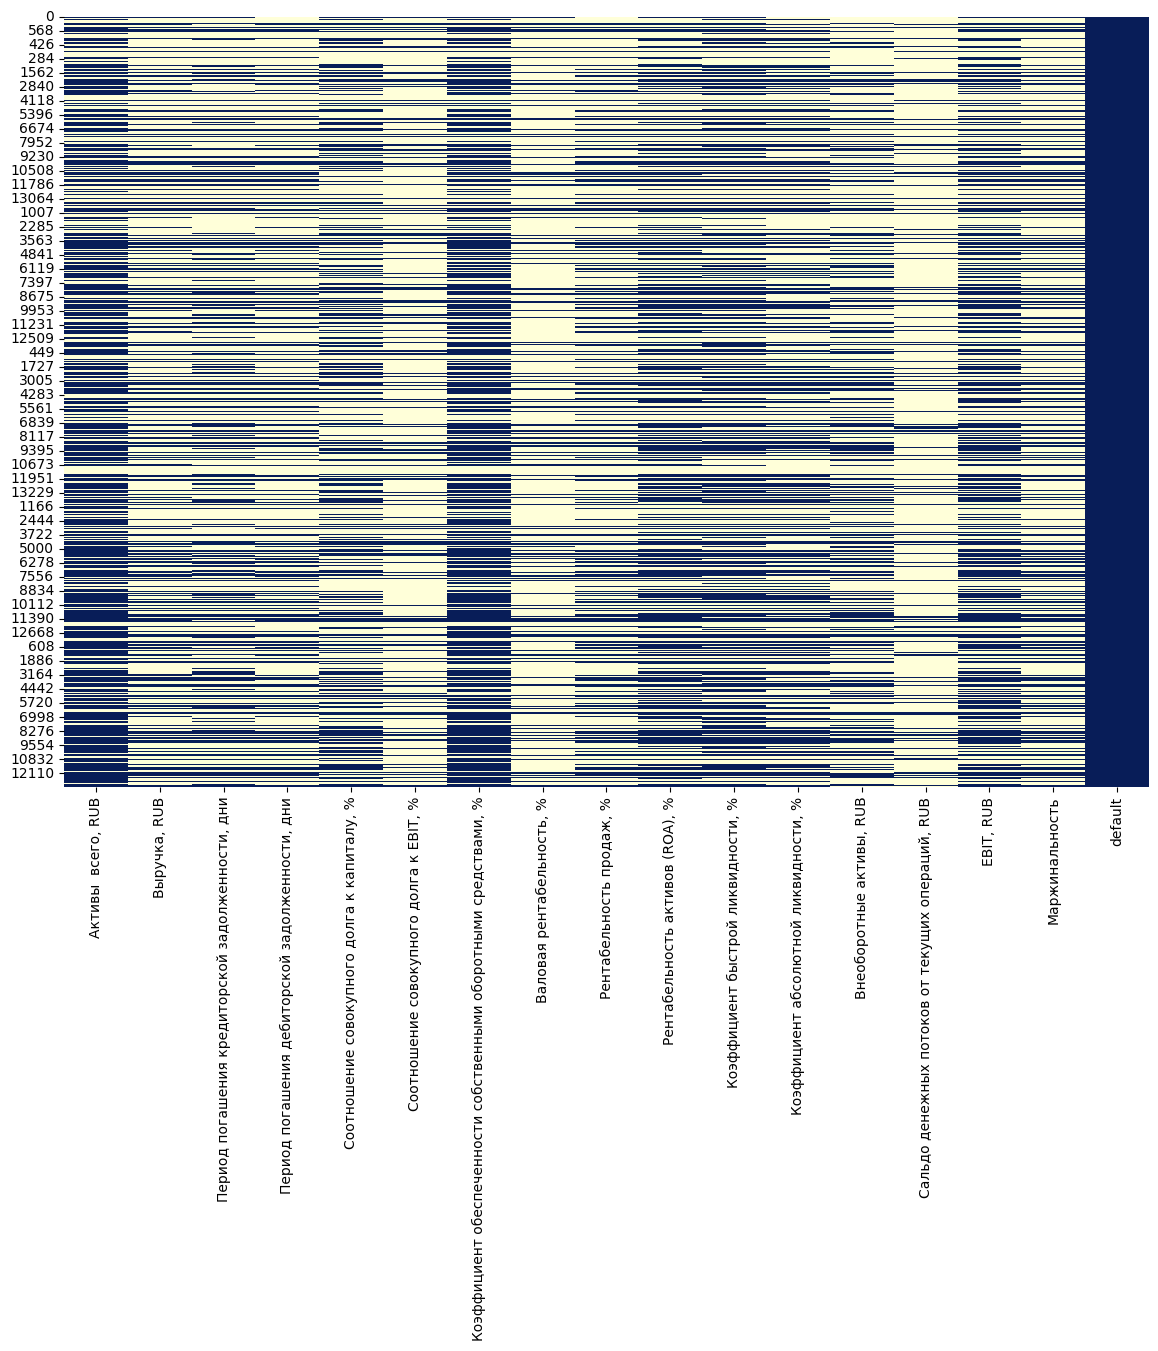

In [8]:
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(data.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

### Убираем пропуски

In [9]:
final_data = data.dropna().copy()

Распределение таргет переменной

default
0    4466
1     163
Name: count, dtype: int64
0.04


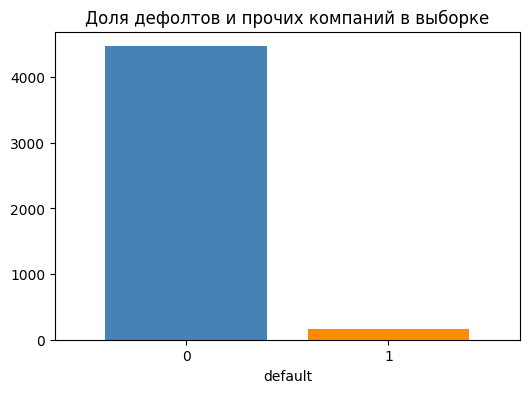

In [10]:
df1 = final_data.default.value_counts()
print(df1)
a=df1[1]/(df1[0]+df1[1])
print(round(a,2))
plt.figure(figsize=(6,4))
plt.title('Доля дефолтов и прочих компаний в выборке')
ax=df1.plot.bar(rot=0, width=0.8, color = ["steelblue", "darkorange"])

Распределение объясняющих признаков

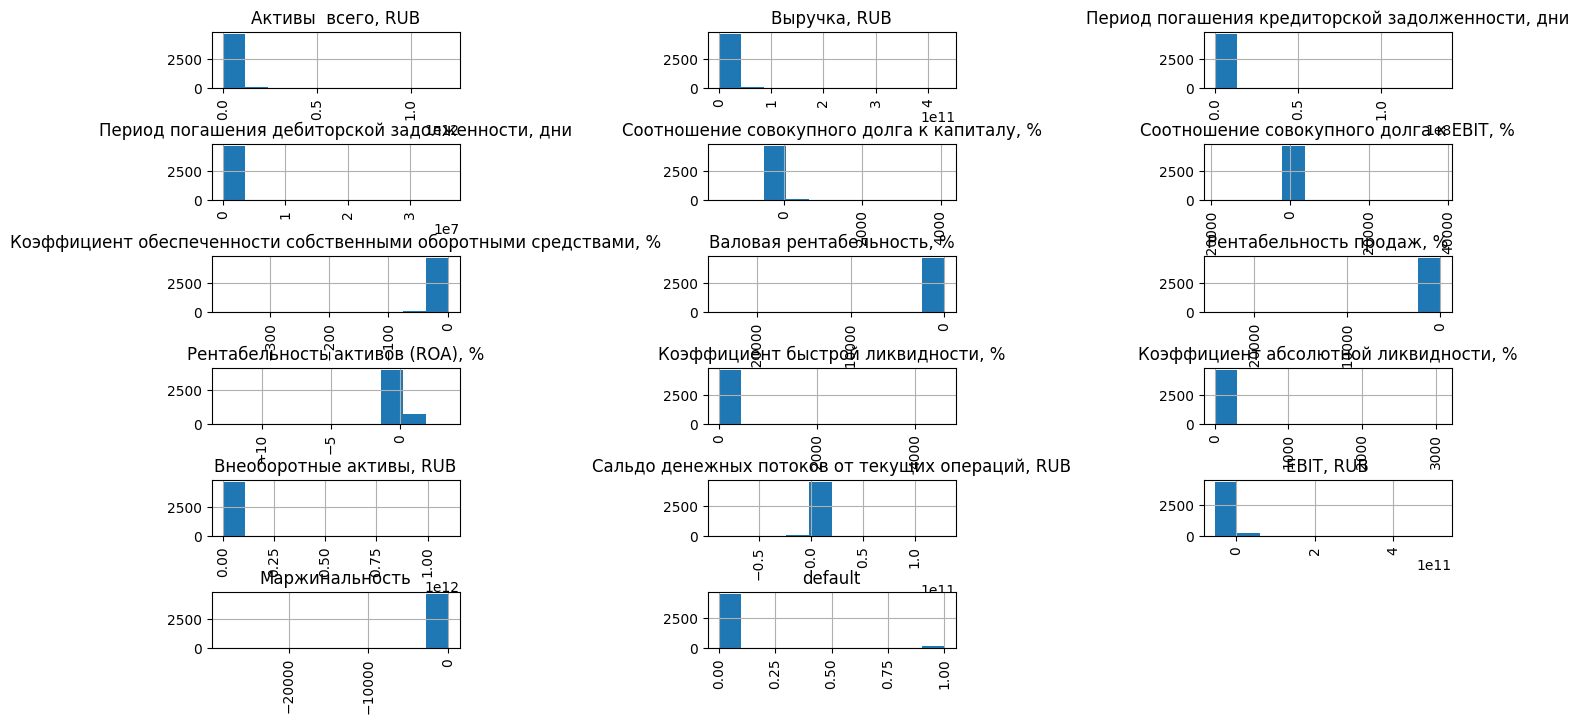

In [11]:
fig = plt.figure(figsize=(16,8))
cols = 3
rows = np.ceil(float(final_data.shape[1]) / cols)
for i, column in enumerate(final_data.columns):
    ax = fig.add_subplot(int(rows), cols, i + 1)
    ax.set_title(column)
    final_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=1, wspace=1)

### Карта корреляций признаков

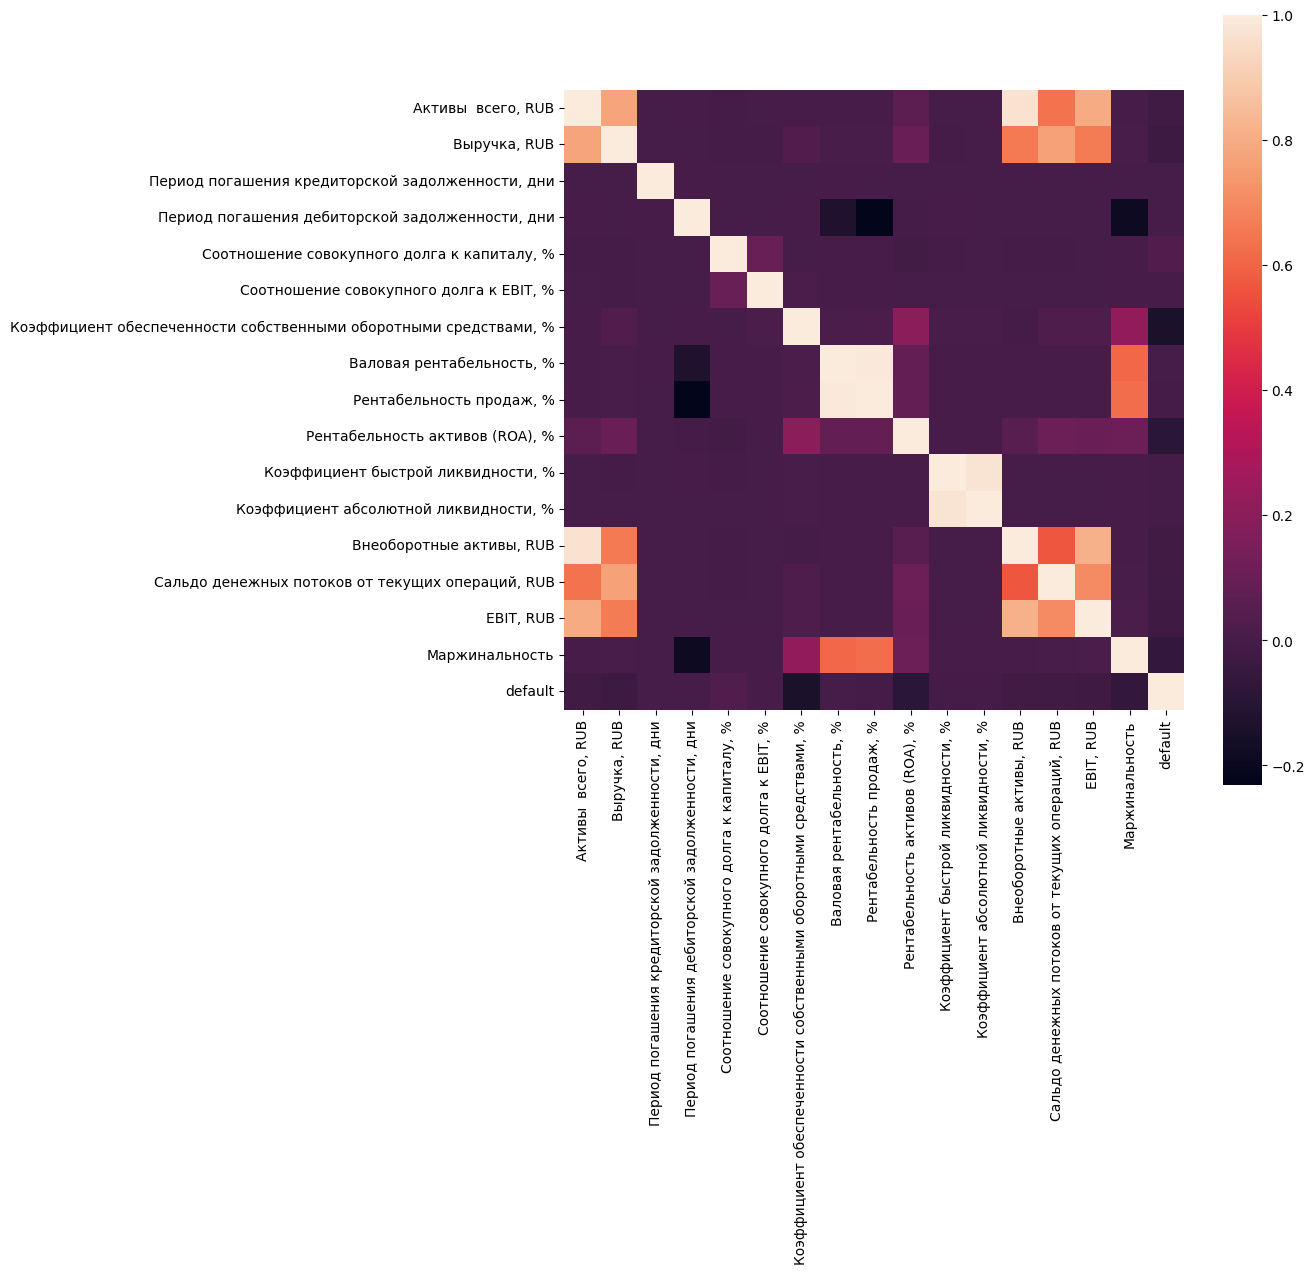

In [12]:
plt.subplots(figsize=(10,10))
sns.heatmap(final_data.corr(), square=True)
plt.show()

### Выбрасываем скоррелированные признаки

In [13]:
usable_columns.remove('Валовая рентабельность, %')
usable_columns.remove('Коэффициент быстрой ликвидности, %')

### Повторяем процедуру сбора данных (возможно, теперь будет больше наблюдений)

In [14]:
defs_short = defs_data[usable_columns].copy()
current_short = current_data[usable_columns].copy()

defs_short['Маржинальность'] = defs_short['EBIT, RUB'] / defs_short['Выручка, RUB']
defs_short['default'] = 1

current_short['Маржинальность'] = current_short['EBIT, RUB'] / current_short['Выручка, RUB']
current_short['default'] = 0

data = pd.concat([defs_short, current_short])
final_data = data.dropna().copy()

default
0    4478
1     164
Name: count, dtype: int64
0.04


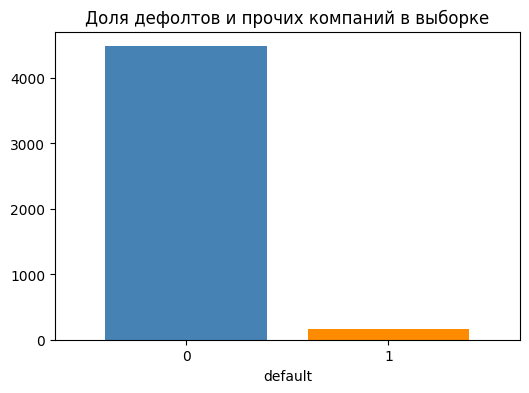

In [15]:
df1 = final_data.default.value_counts()
print(df1)
a=df1[1]/(df1[0]+df1[1])
print(round(a,2))
plt.figure(figsize=(6,4))
plt.title('Доля дефолтов и прочих компаний в выборке')
ax=df1.plot.bar(rot=0, width=0.8, color = ["steelblue", "darkorange"])

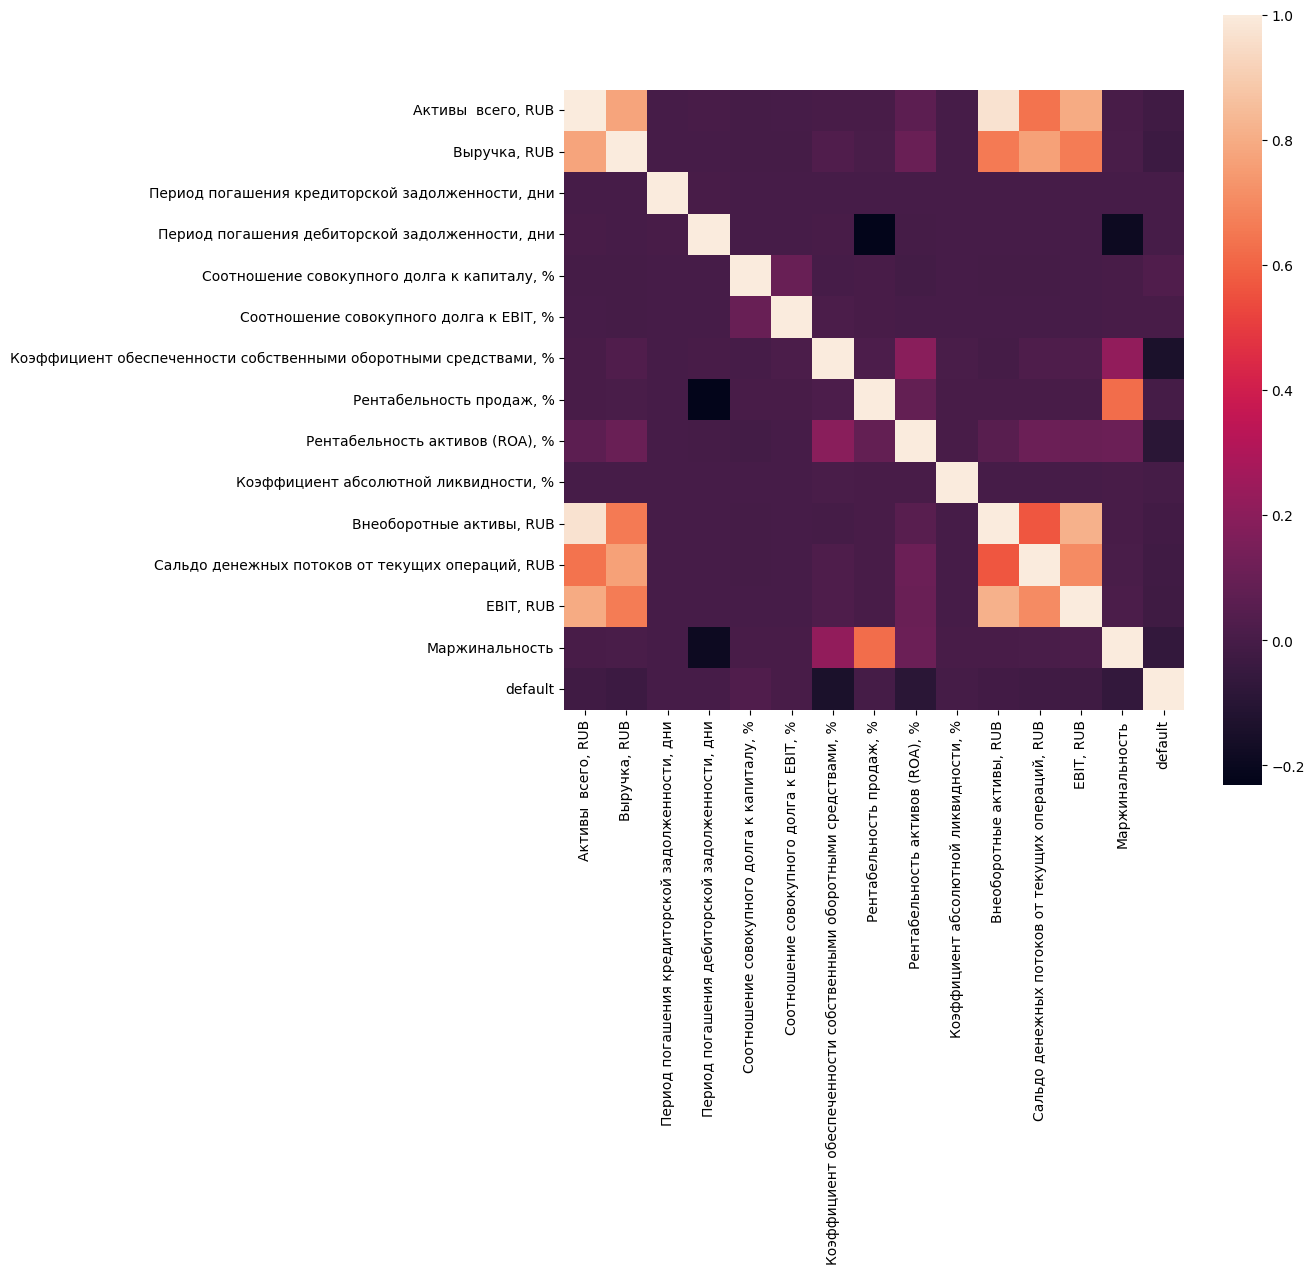

In [16]:
plt.subplots(figsize=(10,10))
sns.heatmap(final_data.corr(), square=True)
plt.show()

### Увы, добавилось только 1 наблюдение

### Функции для аугументации

In [17]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE, ADASYN


def create_polinomial(X, degree = 2):
    return PolynomialFeatures(degree).fit_transform(X)


def oversample_data(X, y):
    return ADASYN(sampling_strategy='not majority').fit_resample(np.array(X), np.array(y))


def oversample_data_S(X, y):
    return SMOTE(sampling_strategy='not majority').fit_resample(np.array(X), np.array(y))


def undersample_data(X, y):
    return TomekLinks(sampling_strategy = 'majority').fit_resample(np.array(X), np.array(y))

## Предпроцессинг

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [19]:
X = final_data.drop(columns=['default']).values
y = final_data['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3249, 14) (1393, 14) (3249,) (1393,)


In [20]:
pd.Series(y_train).value_counts(), pd.Series(y_test).value_counts()

(0    3134
 1     115
 Name: count, dtype: int64,
 0    1344
 1      49
 Name: count, dtype: int64)

In [21]:
#нормализация
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
std = np.where(std == np.zeros(14), np.ones(14), std)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [22]:
#аугментация - TomekLinks
XAU_train, yAU_train = undersample_data(X_train, y_train)
print('после аугментации', XAU_train.shape, X_test.shape)

после аугментации (3198, 14) (1393, 14)


In [23]:
pd.Series(yAU_train).value_counts()

,count
0,3083
1,115


In [24]:
#аугментация - ADASYN
XAO_train, yAO_train = oversample_data(X_train, y_train)
print('после аугментации', XAO_train.shape, X_test.shape)

после аугментации (6242, 14) (1393, 14)


In [25]:
pd.Series(yAO_train).value_counts()

,count
0,3134
1,3108


In [26]:
#аугментация - SMOTE
XAOS_train, yAOS_train = oversample_data_S(X_train, y_train)
print('после аугментации', XAOS_train.shape, X_test.shape)

после аугментации (6268, 14) (1393, 14)


In [27]:
pd.Series(yAOS_train).value_counts()

,count
0,3134
1,3134


In [28]:
d_metrics={}

### SVM

In [30]:
X_train_data_list = [X_train, XAU_train, XAO_train, XAOS_train]
y_train_data_list = [y_train, yAU_train, yAO_train, yAOS_train]
data_name_list = ['SVM_vanila', 'SVM_TomekLinks', 'SVM_ADASYN', 'SVM_SMOTE']

In [ ]:
from sklearn.svm import SVC

for i in range(len(X_train_data_list)):
  X_data  = X_train_data_list[i]
  y_data = y_train_data_list[i]
  # подбор генеральных параметров
  alg = SVC()
  grid = {'C': np.array(np.linspace(0.2 , 2, 10), dtype='float'),
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          }
  gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1)

  gs.fit(X_data, y_data)

  best_params = gs.best_params_

  alg = SVC(C=best_params['C'], kernel =best_params['kernel'])
  alg.fit(X_data, y_data)
  preds = alg.predict(X_test)

  mSVM_WA = metrics.classification_report(y_test, preds, output_dict = True)
  a = mSVM_WA['0']['f1-score']
  b = mSVM_WA['1']['f1-score']
  c = mSVM_WA['accuracy']

  z={'f1_class_0': a,'f1_class_1': b,'accuracy':c}
  d_metrics[data_name_list[i]] = z

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

data_name_list = ['KNN_vanila', 'KNN_TomekLinks', 'KNN_ADASYN', 'KNN_SMOTE']
for i in range(len(X_train_data_list)):
  X_data  = X_train_data_list[i]
  y_data = y_train_data_list[i]
  knn = KNeighborsClassifier()
  knn_grid = {'n_neighbors': np.array(np.linspace(1, 50, num = 50), dtype='int')}
  gs = GridSearchCV(knn, knn_grid)
  gs.fit(X_data, y_data)

  best_params = gs.best_params_

  knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], n_jobs=-1)
  knn.fit(X_data, y_data)
  preds = knn.predict(X_test)

  mSVM_WA = metrics.classification_report(y_test, preds, output_dict = True)
  a = mSVM_WA['0']['f1-score']
  b = mSVM_WA['1']['f1-score']
  c = mSVM_WA['accuracy']

  z={'f1_class_0': a,'f1_class_1': b,'accuracy':c}
  d_metrics[data_name_list[i]] = z

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Логистическая регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression

data_name_list = ['LogReg_vanila', 'LogReg_TomekLinks', 'LogReg_ADASYN', 'LogReg_SMOTE']
for i in range(len(X_train_data_list)):
  X_data  = X_train_data_list[i]
  y_data = y_train_data_list[i]
  alg = LogisticRegression()
  grid = {'penalty': [None, 'l2'],
              'C': np.array(np.logspace(-3, 2, num = 10), dtype='float'),
              }
  gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1)
  gs.fit(X_data, y_data)

  best_params = gs.best_params_

  logreg = LogisticRegression(penalty=best_params['penalty'], C = best_params['C'])
  logreg.fit(X_data, y_data)
  preds = logreg.predict(X_test)

  mSVM_WA = metrics.classification_report(y_test, preds, output_dict = True)
  a = mSVM_WA['0']['f1-score']
  b = mSVM_WA['1']['f1-score']
  c = mSVM_WA['accuracy']

  z={'f1_class_0': a,'f1_class_1': b,'accuracy':c}
  d_metrics[data_name_list[i]] = z

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: T

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: T

### Градиентный бустинг

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

data_name_list = ['GradBoost_vanila', 'GradBoost_TomekLinks', 'GradBoost_ADASYN', 'GradBoost_SMOTE']
for i in range(len(X_train_data_list)):
  X_data  = X_train_data_list[i]
  y_data = y_train_data_list[i]
  clf = GradientBoostingClassifier(random_state=0)
  clf.fit(X_data, y_data)
  preds = clf.predict(X_test)

  mSVM_WA = metrics.classification_report(y_test, preds, output_dict = True)
  a = mSVM_WA['0']['f1-score']
  b = mSVM_WA['1']['f1-score']
  c = mSVM_WA['accuracy']

  z={'f1_class_0': a,'f1_class_1': b,'accuracy':c}
  d_metrics[data_name_list[i]] = z

In [32]:
pd.DataFrame(d_metrics).T

,f1_class_0,f1_class_1,accuracy
GradBoost_vanila,0.981685,0.107143,0.964106
GradBoost_TomekLinks,0.980565,0.101695,0.961953
GradBoost_ADASYN,0.936650,0.234742,0.882986
GradBoost_SMOTE,0.937984,0.223301,0.885140


In [35]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

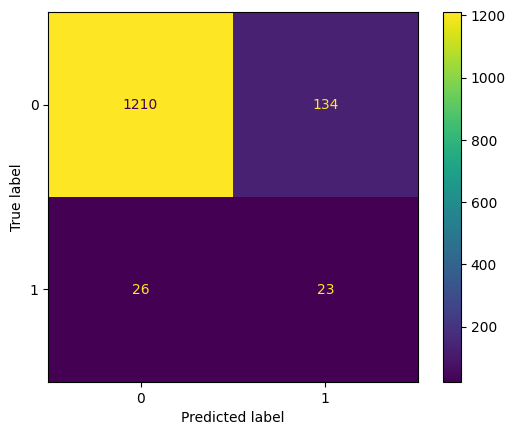

In [36]:
disp.plot()
plt.show()

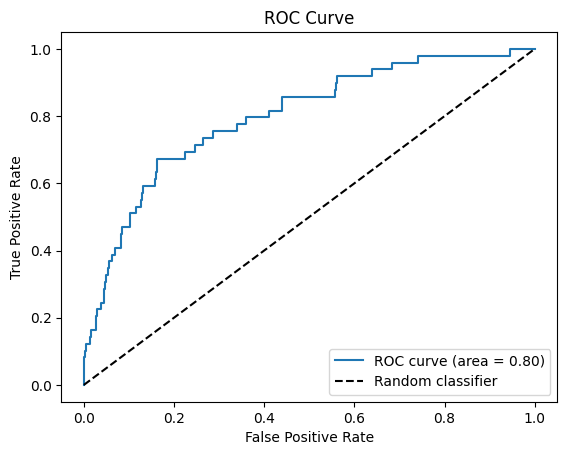

In [40]:
y_pred_prob = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

roc_auc = roc_auc_score(y_test, y_pred_prob)
roc_auc

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Выводы


1.   Агументация позволяет значительно улучшить процесс обучения некоторых модели, лучшая техника агументации для нашего дата-сета SMOTE (хотя ADASYN даёт также хорошее улучшение)
2.   Лучшая модель для нашего дата-сета градиентный бустинг. При обучении без агументации модель заметно лучше работает с классом не дефолтов, при обучении с агументацией лучше находит дефолты, но чаще ошибается с не дефолтами
3.   В качестве итога, считаю лучшей моделью градиентный бустинг с агументацией SMOTE


### Best model

In [ ]:
i = -1
X_data  = X_train_data_list[i]
y_data = y_train_data_list[i]
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_data, y_data)

GradientBoostingClassifier(random_state=0)

Важность признаков

In [ ]:
columns = usable_columns + ['Маржинальность']
feature_importances = {}
for i in range(len(columns)):
  feature_importances[columns[i]] = [clf.feature_importances_[i]]

In [ ]:
pd.DataFrame(feature_importances).T.sort_values(by=[0], ascending=False).rename(columns={0: 'Важность признака'})

,Важность признака
"Период погашения кредиторской задолженности, дни",0.214562
"Соотношение совокупного долга к капиталу, %",0.148777
"Выручка, RUB",0.094906
"Внеоборотные активы, RUB",0.092217
"Рентабельность активов (ROA), %",0.089387
"Период погашения дебиторской задолженности, дни",0.071566
"Коэффициент обеспеченности собственными оборотными средствами, %",0.058494
"Рентабельность продаж, %",0.042259
"Активы всего, RUB",0.041824
"EBIT, RUB",0.039284


from matplotlib import pyplot as plt
_df_0['Важность признака'].plot(kind='hist', bins=20, title='Важность признака')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Важность признака'].plot(kind='line', figsize=(8, 4), title='Важность признака')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
clf.feature_importances_

array([0.04182365, 0.0949057 , 0.21456231, 0.07156604, 0.14877712,
       0.02051912, 0.05849422, 0.0422592 , 0.08938705, 0.03762483,
       0.09221707, 0.03806162, 0.0392842 , 0.01051786])

In [ ]:
usable_columns + ['Маржинальность']

['Активы  всего, RUB',
 'Выручка, RUB',
 'Период погашения кредиторской задолженности, дни',
 'Период погашения дебиторской задолженности, дни',
 'Соотношение совокупного долга к капиталу, %',
 'Соотношение совокупного долга к EBIT, %',
 'Коэффициент обеспеченности собственными оборотными средствами, %',
 'Рентабельность продаж, %',
 'Рентабельность активов (ROA), %',
 'Коэффициент абсолютной ликвидности, %',
 'Внеоборотные активы, RUB',
 'Сальдо денежных потоков от текущих операций, RUB',
 'EBIT, RUB',
 'Маржинальность']